In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Mon Feb 12 15:38:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 38%   65C    P2             131W / 450W |   3677MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Hyper-Parameters

In [4]:
from easydict import EasyDict
hp = EasyDict()

# Data
hp.dataset = 'ffhq_256'
hp.data_root = '/home/scpark/data'
hp.test_eval = True
hp.image_channels = 3
hp.n_batch = 32

# Model
hp.custom_width_str = ""
hp.bottleneck_multiple = 0.25
hp.no_bias_above = 64
hp.num_mixtures = 10
hp.width = 384
hp.zdim = 16
hp.dec_blocks = "1x1,4m1,4x1,8m4,8x1,16m8,16x1,32m16,32x1"
hp.enc_blocks = "32x1,32d2,16x1,16d2,8x1,8d2,4x1,4d4,1x1"

# Train
hp.lr = 0.0002
hp.wd = 0.01
hp.adam_beta1 = 0.9
hp.adam_beta2 = 0.9
hp.warmup_iters = 100
hp.ema_rate = 0.9999
hp.grad_clip = 200.0
hp.skip_threshold = 400.0

### Model

In [5]:
from model.main.vdvae import Model
from model.encoder.vdvae_encoder import Encoder
from model.decoder.vdvae_decoder import Decoder
from model.loss.dmol import Loss

from tensorboardX import SummaryWriter
from util.util import *

In [6]:
step = 0
device = 'cuda:0'

model = Model(Encoder(hp), Decoder(hp), Loss(hp)).to(device)
ema_model = None
optimizer = torch.optim.AdamW(model.parameters(), weight_decay=hp.wd, lr=hp.lr, betas=(hp.adam_beta1, hp.adam_beta2))

for name, module in model.named_modules():
    if len(name.split('.')) <= 1 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 7.7281494140625
decoder 25.4820556640625
loss 0.1468658447265625
done


### Load

In [7]:
save_dir = '/data/save/lse/train_vdvae/train02.12-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, optimizer = load(save_dir, 60000, model, optimizer)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from data.vdvae_data import set_up_data

hp, data_train, data_valid_or_test, preprocess_fn = set_up_data(hp)
hp.image_size = 32
train_loader = DataLoader(data_train, batch_size=hp.n_batch, drop_last=True, pin_memory=True)
print(train_loader)

DOING TEST


### Train

In [9]:
import time
from util.train_helpers import update_ema

def training_step(H, data_input, target, model, ema_model, optimizer):
    model.train()
    model.zero_grad()
    data = {'x': data_input,
            'x_target': target}
    stats = model.forward(data)
    stats['elbo'].backward()
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), H.grad_clip).item()
    distortion_nans = torch.isnan(stats['distortion']).sum()
    rate_nans = torch.isnan(stats['rate']).sum()
    stats.update(dict(rate_nans=0 if rate_nans == 0 else 1, distortion_nans=0 if distortion_nans == 0 else 1))

    skipped_updates = 1
    # only update if no rank has a nan and if the grad norm is below a specific threshold
    if stats['distortion_nans'] == 0 and stats['rate_nans'] == 0 and (H.skip_threshold == -1 or grad_norm < H.skip_threshold):
        optimizer.step()
        skipped_updates = 0
        if ema_model is not None:
            update_ema(model, ema_model, H.ema_rate)

    stats.update(skipped_updates=skipped_updates, grad_norm=grad_norm)
    return stats

def show_samples(model, N):
    model.eval()
    with torch.no_grad():
        samples = model.sample(N)
    plt.figure(figsize=[18, 4])
    for i in range(len(samples)):
        plt.subplot(1, N, i+1)
        plt.imshow(samples[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

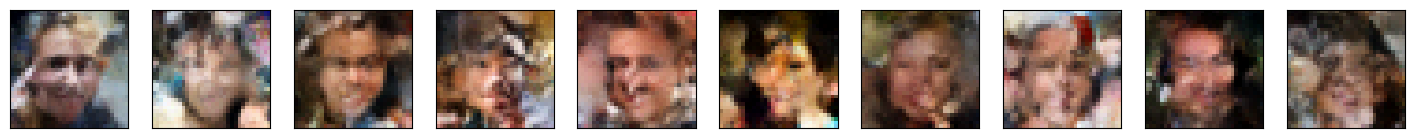

12010 elbo 1.2069876194000244
12020 elbo 1.0920816659927368
12030 elbo 1.188073754310608
12040 elbo 1.2147334814071655
12050 elbo 1.203735113143921
12060 elbo 1.2179560661315918
12070 elbo 1.1542387008666992
12080 elbo 1.181246042251587
12090 elbo 1.161475419998169
12100 elbo 1.133152961730957
12110 elbo 1.1790025234222412
12120 elbo 1.1868582963943481
12130 elbo 1.1417603492736816
12140 elbo 1.1183868646621704
12150 elbo 1.1414743661880493
12160 elbo 1.1832828521728516
12170 elbo 1.1675496101379395
12180 elbo 1.2267245054244995
12190 elbo 1.1905186176300049
12200 elbo 1.228960394859314
12210 elbo 1.1853469610214233
12220 elbo 1.2670691013336182
12230 elbo 1.178931713104248
12240 elbo 1.2104647159576416
12250 elbo 1.165802240371704
12260 elbo 1.1330370903015137
12270 elbo 1.1640007495880127
12280 elbo 1.2089698314666748
12290 elbo 1.227602481842041
12300 elbo 1.2169421911239624
12310 elbo 1.187455654144287
12320 elbo 1.1687343120574951
12330 elbo 1.3182923793792725
12340 elbo 1.1296994

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import torchvision.transforms as transforms

resize = transforms.Resize((hp.image_size, hp.image_size))

while True:
    for x in train_loader:
        x[0] = resize(x[0].permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        data_input, target = preprocess_fn(x)
        data_input = data_input.to(device)
        target = target.to(device)
        stats = training_step(hp, data_input, target, model, ema_model, optimizer)

        if step % 10 == 0:
            print(step, 'elbo', stats['elbo'].item())
            writer.add_scalar('elbo', stats['elbo'].item(), step)
            writer.add_scalar('distortion', stats['distortion'].item(), step)
            writer.add_scalar('rate', stats['rate'].item(), step)
            
        if step % 1000 == 0:
            display.clear_output()
            show_samples(model, 10)
            
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [ ]:
save(save_dir, step, model, optimizer)
print('done')

In [ ]:
import matplotlib.pyplot as plt
show_samples(model, 10)